## MMAI 894 - Deep Learning
Built by Team Alfred

### Import packages.

In [ ]:
import tensorflow as tf
print('GPU version:' , tf.__version__)
import os
import matplotlib.pyplot as plt
import random
import cv2
from shutil import copy
from collections import defaultdict
import collections

GPU version: 2.4.1


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### Download the dataset. This should take up to 5 minutes.

In [ ]:
#mount your google drive.
#it will be visible in the file navigator on the left of this notebook
#there should be a folder in your drive with your data
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
#training folder
!mkdir 'main_data'
!cp -r "/content/gdrive/MyDrive/MMAI/DL/CNN/main_v2.zip" "/content/main_data/"
!unzip '/content/main_data/main_v2.zip' -d '/content/data/'

mkdir: cannot create directory ‘main_data’: File exists
Archive:  /content/main_data/main_v2.zip
replace /content/data/main_v2/.DS_Store? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [ ]:
print('In the directory:' , os.listdir())
print('List within folder:' , os.listdir('data'))
print('List within images:', os.listdir('data/main_v2'))

In the directory: ['.config', 'drive', 'data', 'gdrive', 'main_data', 'sample_data']
List within folder: ['main_v2', '__MACOSX']
List within images: ['plastic_lid', 'plastic_straw', 'paper_bag', 'drink_can', 'plastic_bottle_cap', 'clear_plastic_bottle', 'styrofoam_piece', 'disposable_plastic_cup', 'plastic_utensils', 'pop_tab', 'normal_paper', 'glass_bottle', '.DS_Store', 'paper_straw']


In [ ]:
list_of_waste = [x for x in os.listdir('data/main_v2') if x!='.DS_Store']
list_of_waste.sort()
n_classes = len(list_of_waste)
print(n_classes)


13


Example images of selected wastes...
data/main_v2/clear_plastic_bottle/clear_plastic_bottle12.jpg


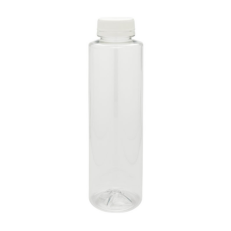

data/main_v2/disposable_plastic_cup/disposable_plastic_cup15.jpeg


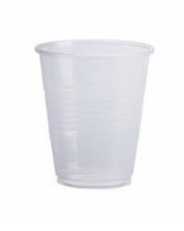

data/main_v2/drink_can/drink_can9.jpg


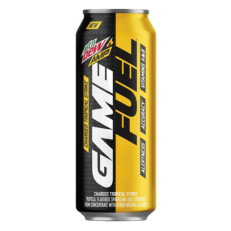

data/main_v2/glass_bottle/glass_bottle04.jpg


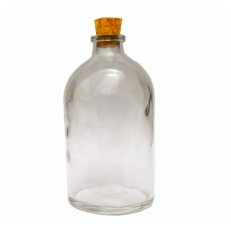

data/main_v2/normal_paper/normal_paper26.jpg


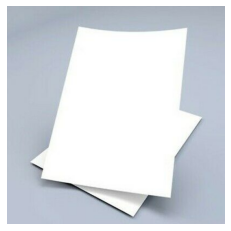

data/main_v2/paper_bag/paper_bag13.jpg


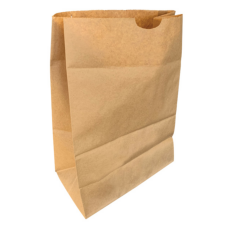

data/main_v2/paper_straw/paper_straw21.jpg


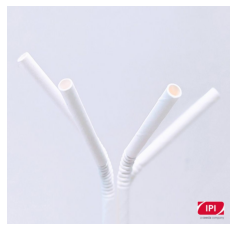

data/main_v2/plastic_bottle_cap/plastic_bottle_cap10.jpg


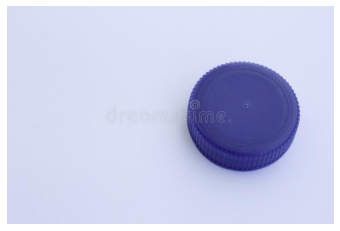

data/main_v2/plastic_lid/plastic_lid09.jpg


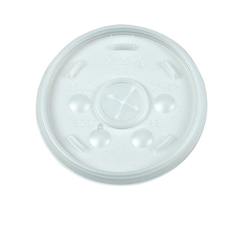

data/main_v2/plastic_straw/plastic_straw09.png


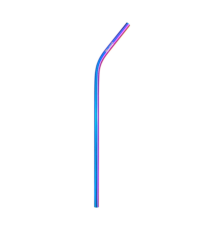

data/main_v2/plastic_utensils/plastic_utensils05.jpg


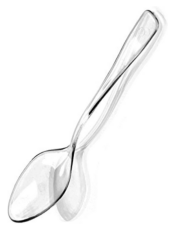

data/main_v2/pop_tab/pop_tab12.jpg


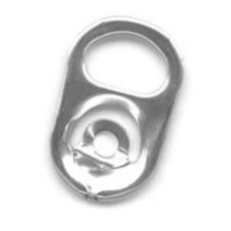

data/main_v2/styrofoam_piece/styrofoam_piece03.jpg


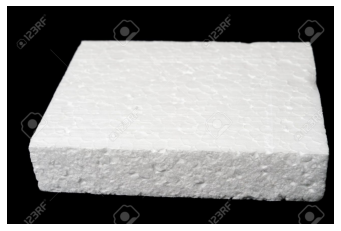

In [ ]:
print('Example images of selected wastes...')
for waste in list_of_waste:
  img = 'data/main_v2/'+waste+'/'+random.choice(os.listdir('data/main_v2/'+waste)) 
  try:
    print(img)
    image = cv2.imread(img)
    plt.axis("off")
    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    plt.show()
  except:
    print(waste, ' not in folder.')

#### Import TensorFlow Modules


In [ ]:
import tensorflow as tf
import tensorflow.keras.backend as K
from tensorflow.keras import regularizers
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten
from tensorflow.keras.layers import Convolution2D, MaxPooling2D, ZeroPadding2D, GlobalAveragePooling2D, AveragePooling2D, GlobalMaxPooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint, CSVLogger
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.regularizers import l2
from tensorflow import keras
import numpy as np


#### Image Augmentation
Image augmentation is a technique to apply transformations to original images that involves shifting, rotating, 
zooming, contrasting etc. This provides more robust model under various image qualities.

For example:
- rotation_range = shocks to rotation of image and *fill_node*=nearest replaces the empty pixel (due to rotation)
with nearby values
- width_shift_range/height_shift_range = Moving object/image out of "center"
- brightness_range = Shock brightness

In [ ]:
!mkdir 'test_data'
!cp -r "/content/gdrive/MyDrive/MMAI/DL/Testing Images/" "/content/test_data/"

mkdir: cannot create directory ‘test_data’: File exists


In [ ]:
#deletes old and starts anew
K.clear_session()
train_data_dir = '/content/data/main_v2/'
#test_data_dir = '/content/test_data/Testing Images'
#nb_train_samples, nb_validation_samples = 2250, 750
batch_size = 64

train_imgdatagen = ImageDataGenerator(
    rotation_range=25,
    width_shift_range=0.2, 
    height_shift_range=0.2,
    rescale=1. / 255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    vertical_flip=True,
    brightness_range=[0.4,1.5],
    fill_mode='nearest',
    validation_split=0.2)

train_datagen = train_imgdatagen.flow_from_directory(
    train_data_dir,
    batch_size=batch_size,
    seed = 23,
    class_mode='categorical',
    subset='training')

#validation_generator = (
#    test_data_dir, 
#    batch_size=batch_size,
#    class_mode='categorical',
#    subset='validation')

validation_generator = train_imgdatagen.flow_from_directory(
    train_data_dir,
    seed = 23,
    class_mode='categorical',
    subset='validation')


inception = InceptionV3(weights='imagenet', include_top=False)
x = inception.output
x = GlobalAveragePooling2D()(x)
x = Dense(512,activation='relu')(x) #layer
x = Dense(256,activation='relu')(x) #layer
#Softmax function is frequently used for classification tasks (prediction)
predictions = Dense(13, activation='softmax')(x)
model = Model(inputs=inception.input, outputs=predictions)
for layer in inception.layers: 
    layer.trainable = False

model.compile(optimizer=SGD(), loss='categorical_crossentropy', metrics=['accuracy'])
#Stochastic Gradient Descent

history = model.fit(train_datagen,
          validation_data=validation_generator,
          epochs=50,
          verbose=1)

model.save('Alfred_model_trained_CNN3.hdf5')
print ('Model trained & saved')

Found 239 images belonging to 13 classes.
Found 53 images belonging to 13 classes.
Epoch 1/50
4/4 [==============================] - 18s 4s/step - loss: 2.7202 - accuracy: 0.0763 - val_loss: 2.4890 - val_accuracy: 0.1887
Epoch 2/50
4/4 [==============================] - 10s 3s/step - loss: 2.4739 - accuracy: 0.1793 - val_loss: 2.4250 - val_accuracy: 0.2453
Epoch 3/50
4/4 [==============================] - 10s 3s/step - loss: 2.4056 - accuracy: 0.2721 - val_loss: 2.2748 - val_accuracy: 0.3396
Epoch 4/50
4/4 [==============================] - 10s 3s/step - loss: 2.2622 - accuracy: 0.3688 - val_loss: 2.1777 - val_accuracy: 0.4340
Epoch 5/50
4/4 [==============================] - 10s 3s/step - loss: 2.1506 - accuracy: 0.4514 - val_loss: 2.0614 - val_accuracy: 0.4717
Epoch 6/50
4/4 [==============================] - 10s 3s/step - loss: 2.0379 - accuracy: 0.4899 - val_loss: 1.9935 - val_accuracy: 0.5472
Epoch 7/50
4/4 [==============================] - 10s 3s/step - loss: 1.9423 - accuracy: 

Text(0.5, 1.0, 'CNN Model Accuracy & Loss Results')

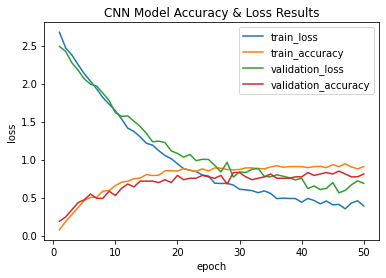

In [ ]:
xData =[i for i in range(1,51)]
for key in history.history.keys():
  plt.plot(xData,history.history[key])
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train_loss','train_accuracy', 'validation_loss', 'validation_accuracy'], loc='best')
plt.title('CNN Model Accuracy & Loss Results')

### Use the model.

In [ ]:
# Loading the best saved model to make predictions
%%time
import tensorflow.keras.backend as K
from tensorflow.keras.models import load_model

K.clear_session()
model_best = load_model('Alfred_model_trained_CNN3.hdf5',compile = False)

CPU times: user 2.26 s, sys: 90.7 ms, total: 2.35 s
Wall time: 2.31 s


In [ ]:
from tensorflow.keras.preprocessing import image
import matplotlib.pyplot as plt
import numpy as np

def predict_class(model, img, show = True):
  img = image.img_to_array(image.load_img(img, target_size=(299, 299)))                    
  img = np.expand_dims(img, axis=0)         
  img /= 255.                                      

  pred = model.predict(img)
  index = np.argmax(pred)
  pred_value = list_of_waste[index]
  plt.imshow(img[0])
  plt.axis('off')
  plt.title(pred_value)
  plt.show()

def predict_class_name(model, img, show = True):
  img = image.img_to_array(image.load_img(img, target_size=(299, 299)))                    
  img = np.expand_dims(img, axis=0)         
  img /= 255.                                      

  pred = model.predict(img)
  index = np.argmax(pred)
  pred_value = list_of_waste[index]
  return pred_value

In [ ]:
from tensorflow.keras.preprocessing import image

!wget -O pic2.jpg https://i2.wp.com/thecottagemarket.com/wp-content/uploads/2017/08/PaperBagCrafts6.jpg

# (pass) disposable_plastic_cup - https://sc04.alicdn.com/kf/HTB1Zqf4KFXXXXbdXXXXq6xXFXXXc.jpg
# (pass) disposable_plastic_cup - https://www.kozzi.com/wp-content/uploads/2020/08/Group-of-red-disposable-plastic-cups-300dpi.jpg
# (pass) pop-tab - https://www.kozzi.com/wp-content/uploads/2020/08/Group-of-red-disposable-plastic-cups-300dpi.jpg
# (pass) pop-tab - https://www.crafts-for-all-seasons.com/images/xpop-tab-craft-02.jpg.pagespeed.ic.EGT-3uPM1E.jpg
# (fail) glass-bottle - https://www.lcbo.com/content/dam/lcbo/products/000018.jpg/jcr:content/renditions/cq5dam.web.1280.1280.jpeg
# (pass) glass-bottle - https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcRd5W5Mx6WBLLJhT4Ea-XsYDysymZTiudgQug&usqp=CAU
# (pass) glass-bottle - https://bcartifacts.com/wordpress/wp-content/uploads/beer3b.jpg
# (pass) styrofoam_piece - https://www.intcorecycling.com/pics/Styrofoam%20waste.png
# (pass) styrofoam_piece - https://recollect-images.global.ssl.fastly.net/api/image/500/06e5bb0c-1955-11eb-ab7c-4a87e10816fb.svg
# (pass) paperbag - https://post.psychcentral.com/wp-content/uploads/2020/04/Woman-Holding-A-Shopping-Bag-1200x628-facebook-1-1200x628.jpg
# (pass) paperbag - https://i2.wp.com/thecottagemarket.com/wp-content/uploads/2017/08/PaperBagCrafts6.jpg


--2021-03-29 04:24:51--  https://i2.wp.com/thecottagemarket.com/wp-content/uploads/2017/08/PaperBagCrafts6.jpg
Resolving i2.wp.com (i2.wp.com)... 192.0.77.2
Connecting to i2.wp.com (i2.wp.com)|192.0.77.2|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 76015 (74K) [image/jpeg]
Saving to: ‘pic2.jpg’

pic2.jpg            100%[===================>]  74.23K  --.-KB/s    in 0.02s   

2021-03-29 04:24:51 (2.93 MB/s) - ‘pic2.jpg’ saved [76015/76015]



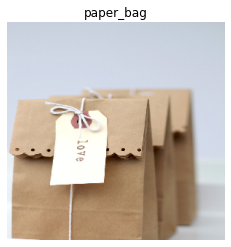

In [ ]:
predict_class(model_best, 'pic2.jpg', True)

waste    0.8
dtype: float64

In [ ]:
import pandas as pd
loc = os.listdir('/content/test_data/Testing Images')
results = {}
for waste in loc:
  listed = []
  if waste != 'testing_dataset.zip':
    try:
      print('\nFolder:',waste)
      count = 0
      for img in os.listdir('/content/test_data/Testing Images/'+waste+'/'):
        pic = '/content/test_data/Testing Images/'+waste+'/'+img
      #print(pic)
        x = predict_class_name(model_best,pic,True)
        listed.append(x)
      df = pd.DataFrame(listed)
      df.columns = ['waste']
      results[waste]=df[df['waste']==waste].count()/10
      print(df)
    except:
      print('error')
print (results)


Folder: plastic_lid
                  waste
0  clear_plastic_bottle
1           plastic_lid
2    plastic_bottle_cap
3             drink_can
4           plastic_lid
5           plastic_lid
6           plastic_lid
7           plastic_lid
8           plastic_lid
9    plastic_bottle_cap

Folder: aluminum_foil
                    waste
0                 pop_tab
1         styrofoam_piece
2         styrofoam_piece
3               paper_bag
4         styrofoam_piece
5         styrofoam_piece
6         styrofoam_piece
7               drink_can
8         styrofoam_piece
9  disposable_plastic_cup

Folder: plastic_straw
             waste
0      paper_straw
1      paper_straw
2      paper_straw
3      paper_straw
4          pop_tab
5      paper_straw
6  styrofoam_piece
7    plastic_straw
8    plastic_straw
9      paper_straw

Folder: paper_bag
                  waste
0             paper_bag
1             paper_bag
2             paper_bag
3  clear_plastic_bottle
4             paper_bag
5          

In [ ]:
pd.DataFrame(data=results)

,plastic_lid,aluminum_foil,plastic_straw,paper_bag,drink_can,plastic_bottle_cap,clear_plastic_bottle,aluminum_tray,styrofoam_piece,disposable_plastic_cup,plastic_utensils,pop_tab,normal_paper,glass_bottle,battery,paper_straw
waste,0.6,0.0,0.2,0.7,0.7,0.9,0.9,0.0,0.8,1.0,0.8,0.7,0.7,0.5,0.0,0.8
